In [114]:
import numpy as np
import matplotlib.pyplot as plt
import torch    


import sys
sys.path.append('..')

# reload in jupyter
%load_ext autoreload
%autoreload 2

from mix_NCA.utils_simulations import grid_to_channels_batch, train_nca_dyn, plot_nca_prediction, classification_update_net, plot_nca_prediction2, plot_automata_comparison_grid
from mix_NCA.NCA import NCA 
from mix_NCA.MixtureNCA import MixtureNCA
from mix_NCA.TissueModel import ComplexCellType, TissueModel, create_simple_model_example, plot_cell_type_evolution
from mix_NCA.MixtureNCANoise import MixtureNCANoise


# seet seed
np.random.seed(42)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


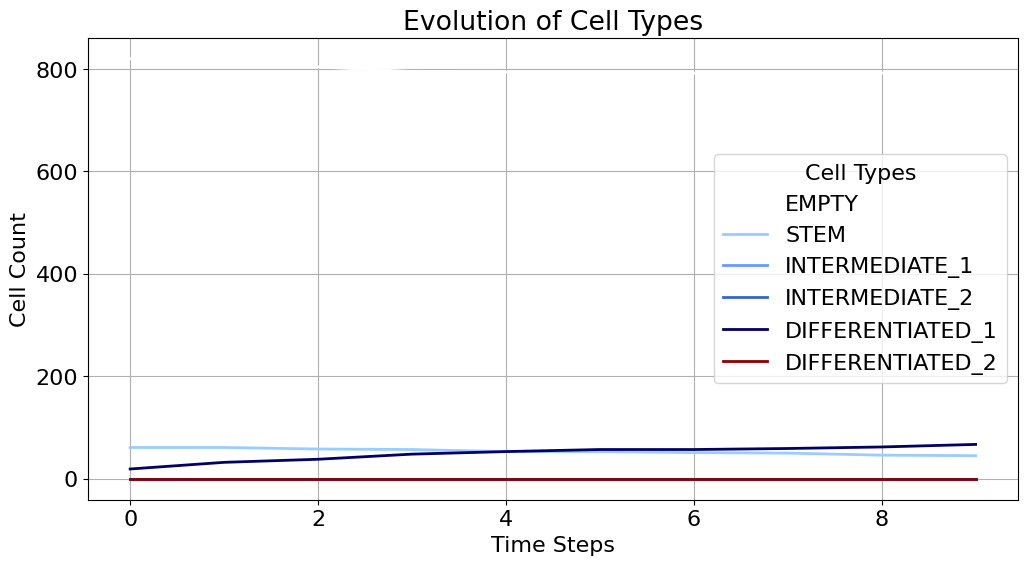

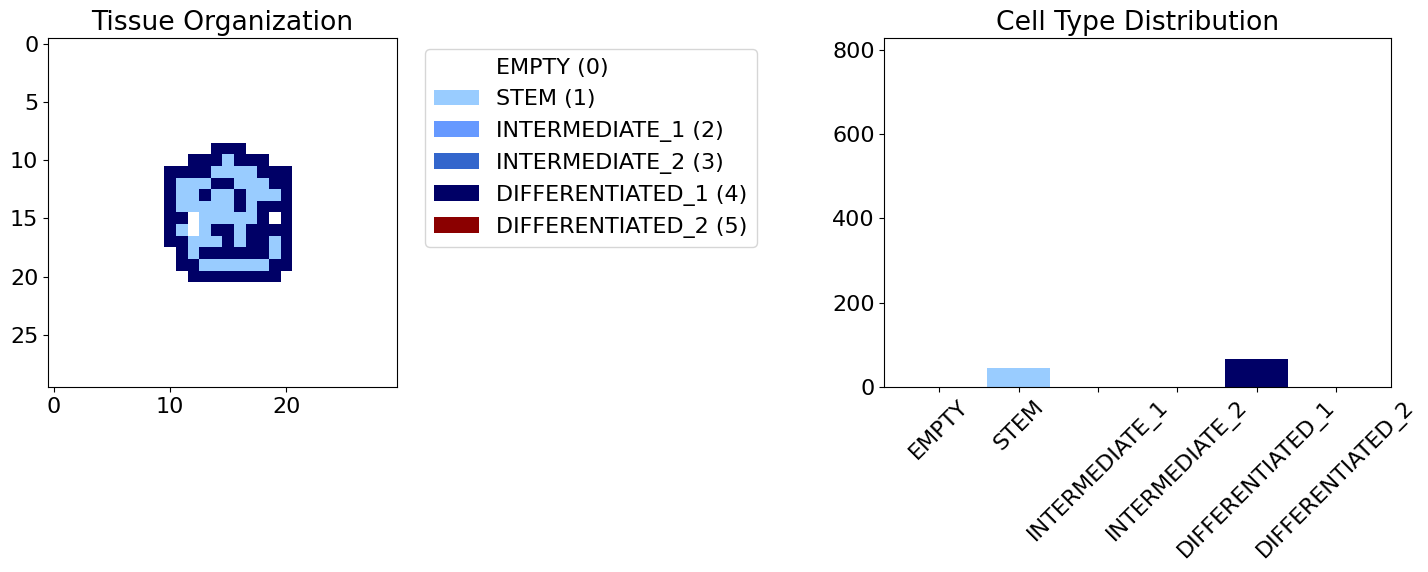

In [115]:
# Create and run model
model = create_simple_model_example(30)

# Run simulation
steps = 10
history = []
for _ in range(steps):
    model.step()
    history.append(model.grid.copy())

# Plot results
plot_cell_type_evolution(history)

# Plot final state
model.plot_tissue(show_statistics=True)

In [116]:
NSTEPS = 15
N_SIMULATIONS = 200
histories = []
spatial_models = []
for i in range(N_SIMULATIONS):
    n_stems = np.random.randint(15, high=20)
    model = create_simple_model_example(n_stems)
    history, _ = model.simulate(NSTEPS)
    histories.append(history)
    spatial_models.append(model)

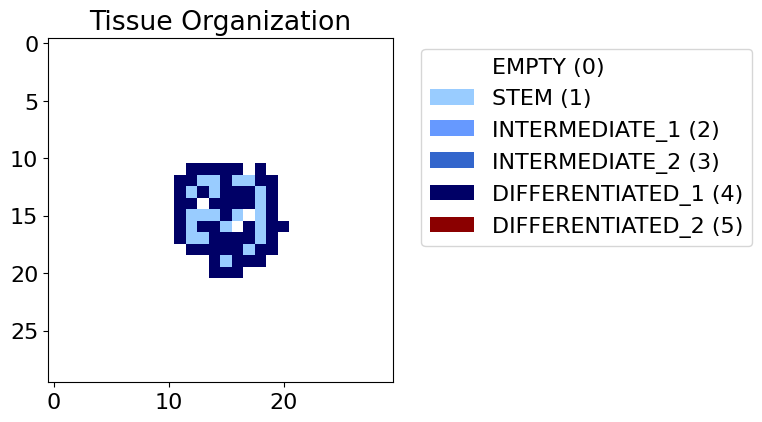

In [117]:
# change size of the plot and font size
plt.rcParams['figure.figsize'] = [30, 12]
plt.rcParams['font.size'] = 16

spatial_models[30].plot_tissue(show_statistics=False)

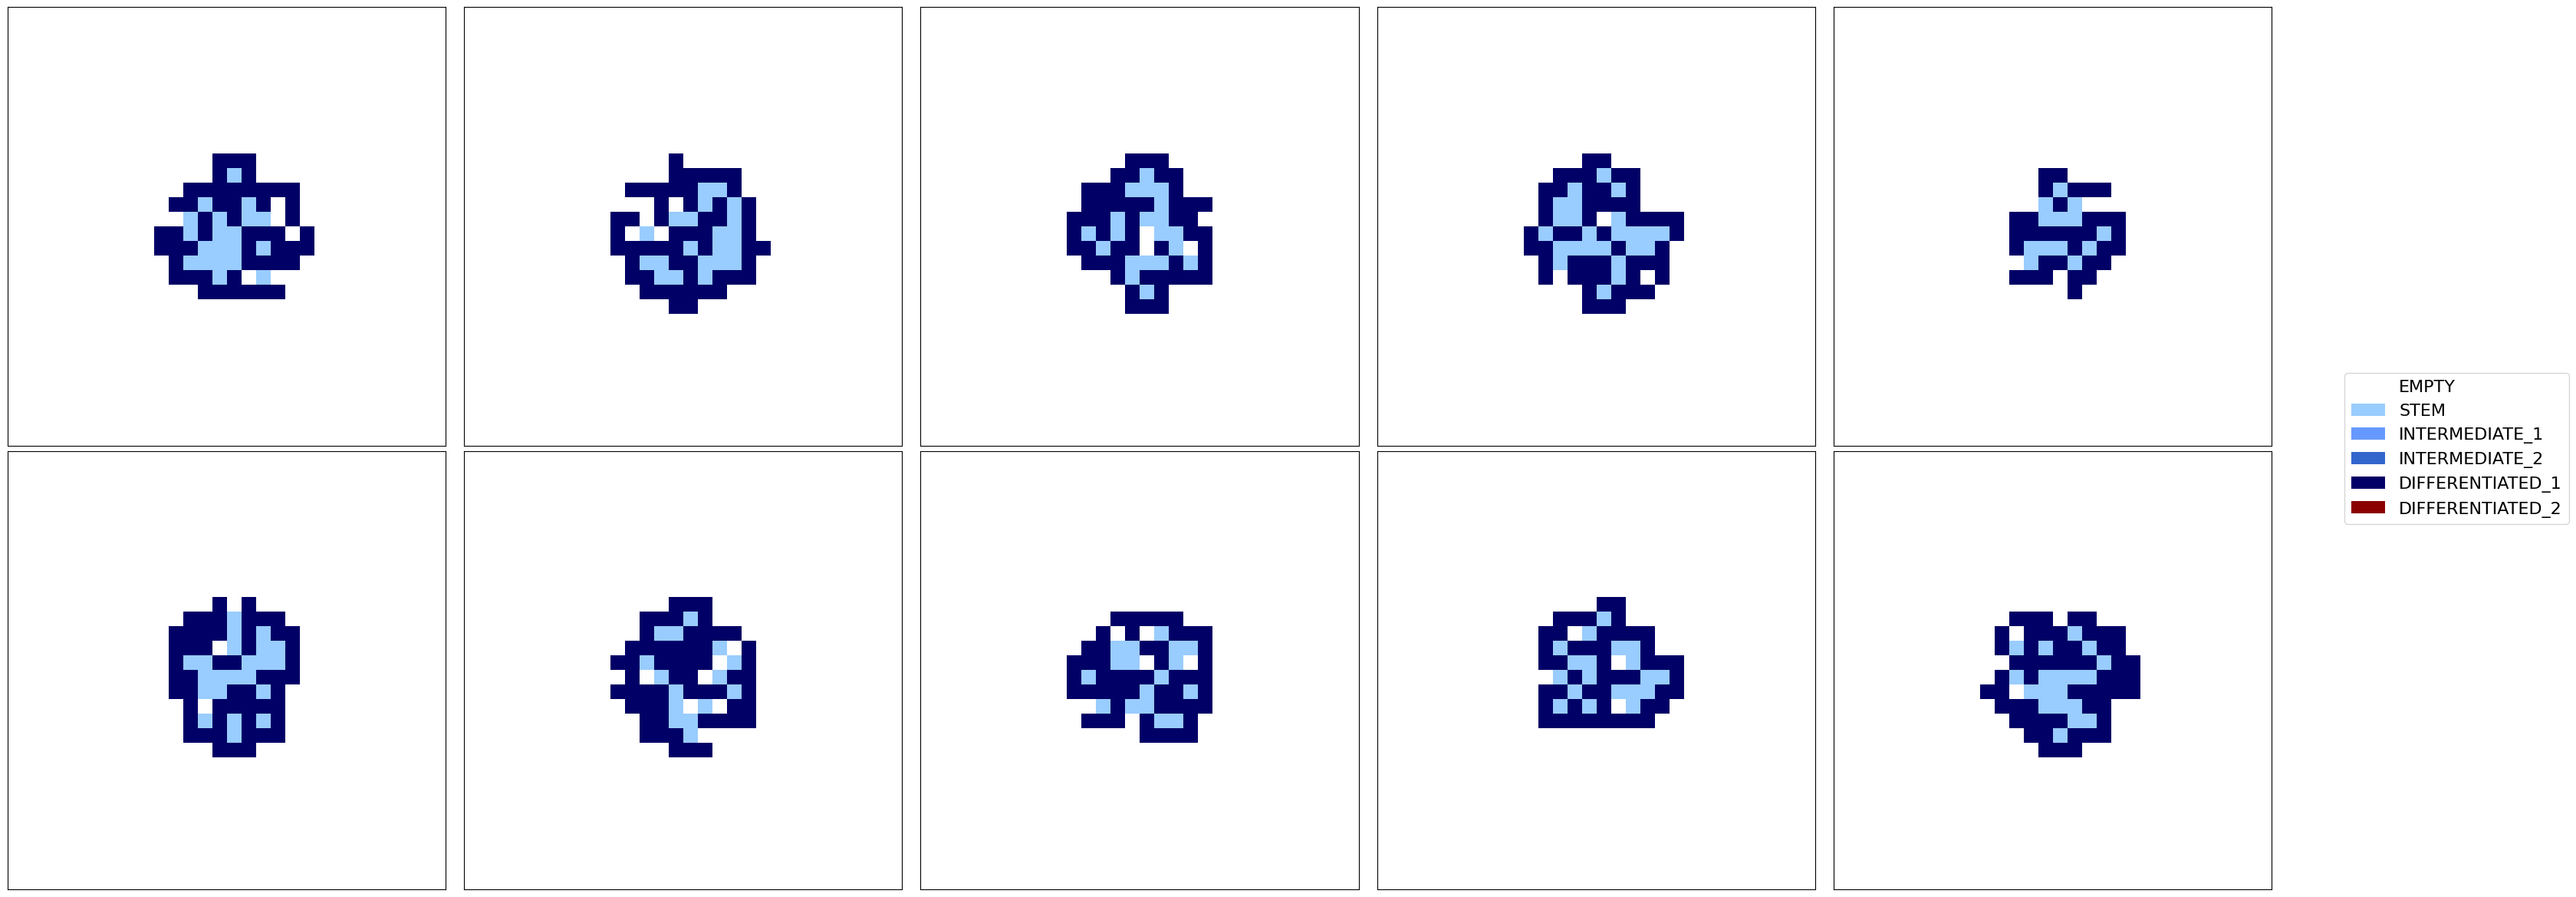

In [118]:
# Create a figure with 2 rows and 6 columns
fig, axes = plt.subplots(2, 5, figsize=(30, 12))

# Get colors from ComplexCellType enum via TissueModel
colors = [cell_type.get_color() for cell_type in ComplexCellType]
cmap = plt.cm.colors.ListedColormap(colors)

# Plot models in grid 
for i in range(2):
    for j in range(5):
        model_idx = i*5 + j
        ax = axes[i,j]
        grid = spatial_models[model_idx].grid
        im = ax.imshow(grid, cmap=cmap, vmin=0, vmax=len(ComplexCellType)-1)
        ax.set_xticks([])
        ax.set_yticks([])

# Add a common colorbar
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=cell_type.get_color(), label=f"{cell_type.name}")
    for cell_type in ComplexCellType
]
fig.legend(handles=legend_elements, bbox_to_anchor=(1.02, 0.5), loc='center left')
        
plt.tight_layout()



In [120]:
mix_nca = MixtureNCA(update_nets = classification_update_net, hidden_dim = 128, 
                     maintain_seed = False, use_alive_mask = False, state_dim = 6, 
                     num_rules = 2, residual = False, device = "cuda:3", temperature=1)

In [123]:
train_nca_dyn(model=mix_nca, target_states=histories,n_cell_types = 6, n_epochs=800, time_length = 16, 
              update_every = 1, device = "cuda:3",
               temperature = 5, min_temperature = 0.1, anneal_rate = 0.006, lr = 0.001)

Precomputing grid representations...


Training NCA (mse):   0%|          | 0/800 [00:00<?, ?it/s]

Training NCA (mse): 100%|██████████| 800/800 [01:33<00:00,  8.58it/s, loss=0.001818, window=0-16]


0.029089783784002066

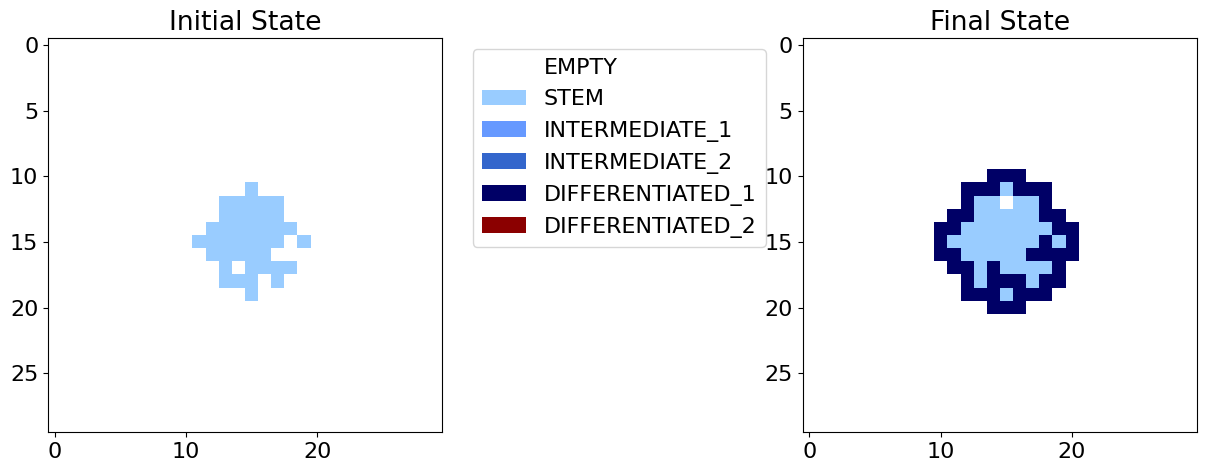

In [124]:
plot_nca_prediction(mix_nca, histories[10][0],steps = 15,n_cell_types = 6,
                     cell_type_enum = ComplexCellType , 
                    show_intermediate = False, random = True, random_seed = 3)

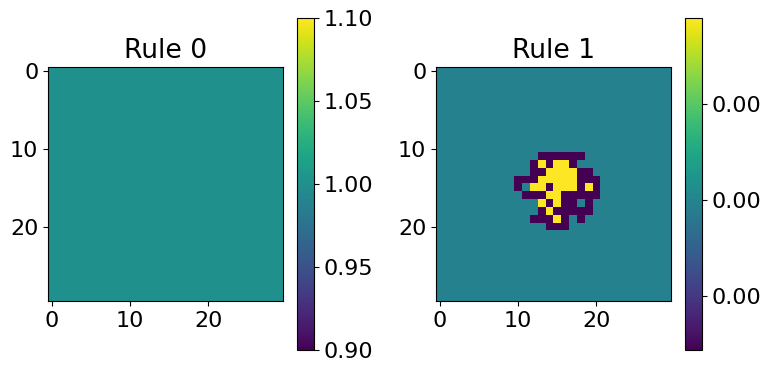

In [125]:
x = grid_to_channels_batch(grids=histories[10], n_cell_types=6, device = "cuda:1")
mix_nca.to("cuda:1")
_ = mix_nca.visualize_rule_assignments(x[9:].to("cuda:1"))

In [126]:
torch.save(mix_nca.state_dict(), "mix_nca_prova_noise.pth")


In [132]:
stochastic_mix_nca = MixtureNCANoise(update_nets = classification_update_net, hidden_dim = 128,
                                      maintain_seed = False, use_alive_mask = False, state_dim = 6, num_rules = 2, 
                                     residual = False, device = "cuda:3", temperature=3)



In [133]:
train_nca_dyn(model=stochastic_mix_nca, target_states=histories,n_cell_types = 6, n_epochs=800,
               time_length = 16, update_every = 1, device = "cuda:3", lr = 0.001, 
               temperature = 3, min_temperature = 0.1, anneal_rate = 0.006)

Precomputing grid representations...


Training NCA (mse):   0%|          | 0/800 [00:00<?, ?it/s]

Training NCA (mse): 100%|██████████| 800/800 [01:40<00:00,  7.93it/s, loss=0.002225, window=0-16]


0.03560120228212327

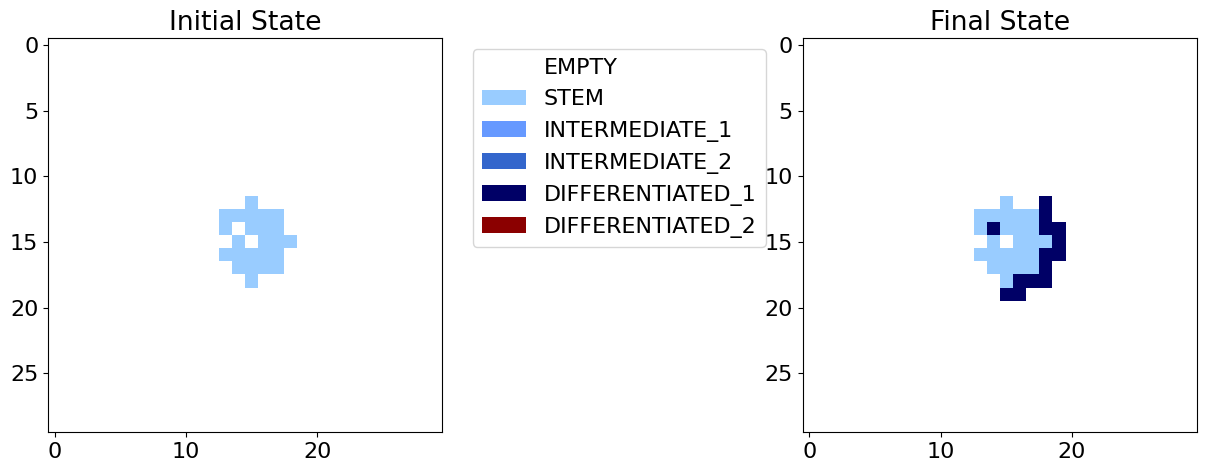

In [135]:
plot_nca_prediction(stochastic_mix_nca, histories[11][0],steps = 15,n_cell_types = 6,
                    cell_type_enum = ComplexCellType , show_intermediate = False, random = True,
                    random_seed = 3, device = "cuda:3")

In [130]:
# save the model
torch.save(stochastic_mix_nca.state_dict(), "stochastic_mix_nca_prova_noise.pth")


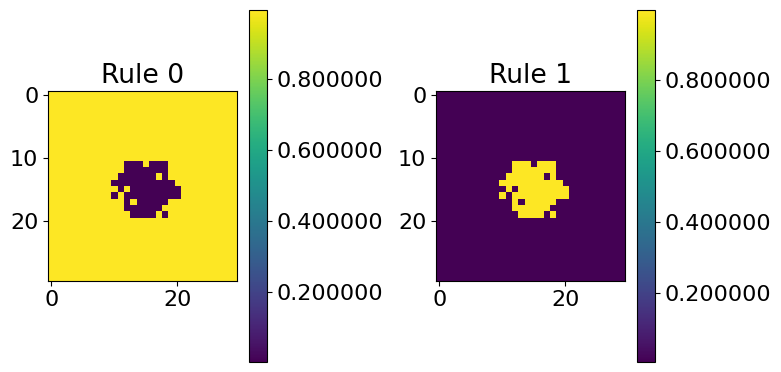

In [90]:
x = grid_to_channels_batch(grids=histories[10], n_cell_types=6, device = "cuda:3")
_ = stochastic_mix_nca.visualize_rule_assignments(x[10:])

In [91]:
inital_state = x[4].unsqueeze(0)
num_trials = 1000
num_steps = 1

stochastic_mix_nca.save_internal_noise = True

all_outputs = []
noise_outputs = []
for i in range(num_trials):
    torch.manual_seed(i)
    with torch.no_grad():
        outputs = stochastic_mix_nca(inital_state.clone(), num_steps, return_history=False, sample_non_differentiable=False)

        all_outputs.append(outputs.cpu().numpy())
        noise_outputs.append(stochastic_mix_nca.internal_noise.cpu().numpy())
all_outputs = np.array(all_outputs)  # [num_trials, num_steps, batch, channels, height, width]
noise_outputs = np.array(noise_outputs)  # [num_trials, num_steps, batch, channels, height, width]

In [92]:
noise_values = noise_outputs.squeeze()
noise_values[noise_values == 0] = -np.inf
noise_values = np.max(noise_values, axis = 1)

# get the point with the highest change in the update
points = np.unravel_index(np.argmax(np.std(np.argmax(all_outputs.squeeze(1), axis = 1), axis = 0)), all_outputs.squeeze(1)[:,0, 0].shape)


/tmp/ipykernel_4032772/263825637.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  plt.scatter(noise_values[:,points[0],points[1]].flatten(), all_outputs.squeeze(1)[:,0, points[0], points[1]].flatten(),  cmap='viridis', norm=plt.cm.colors.LogNorm())


Text(0.5, 1.0, '2D Histogram of Noise vs Update')

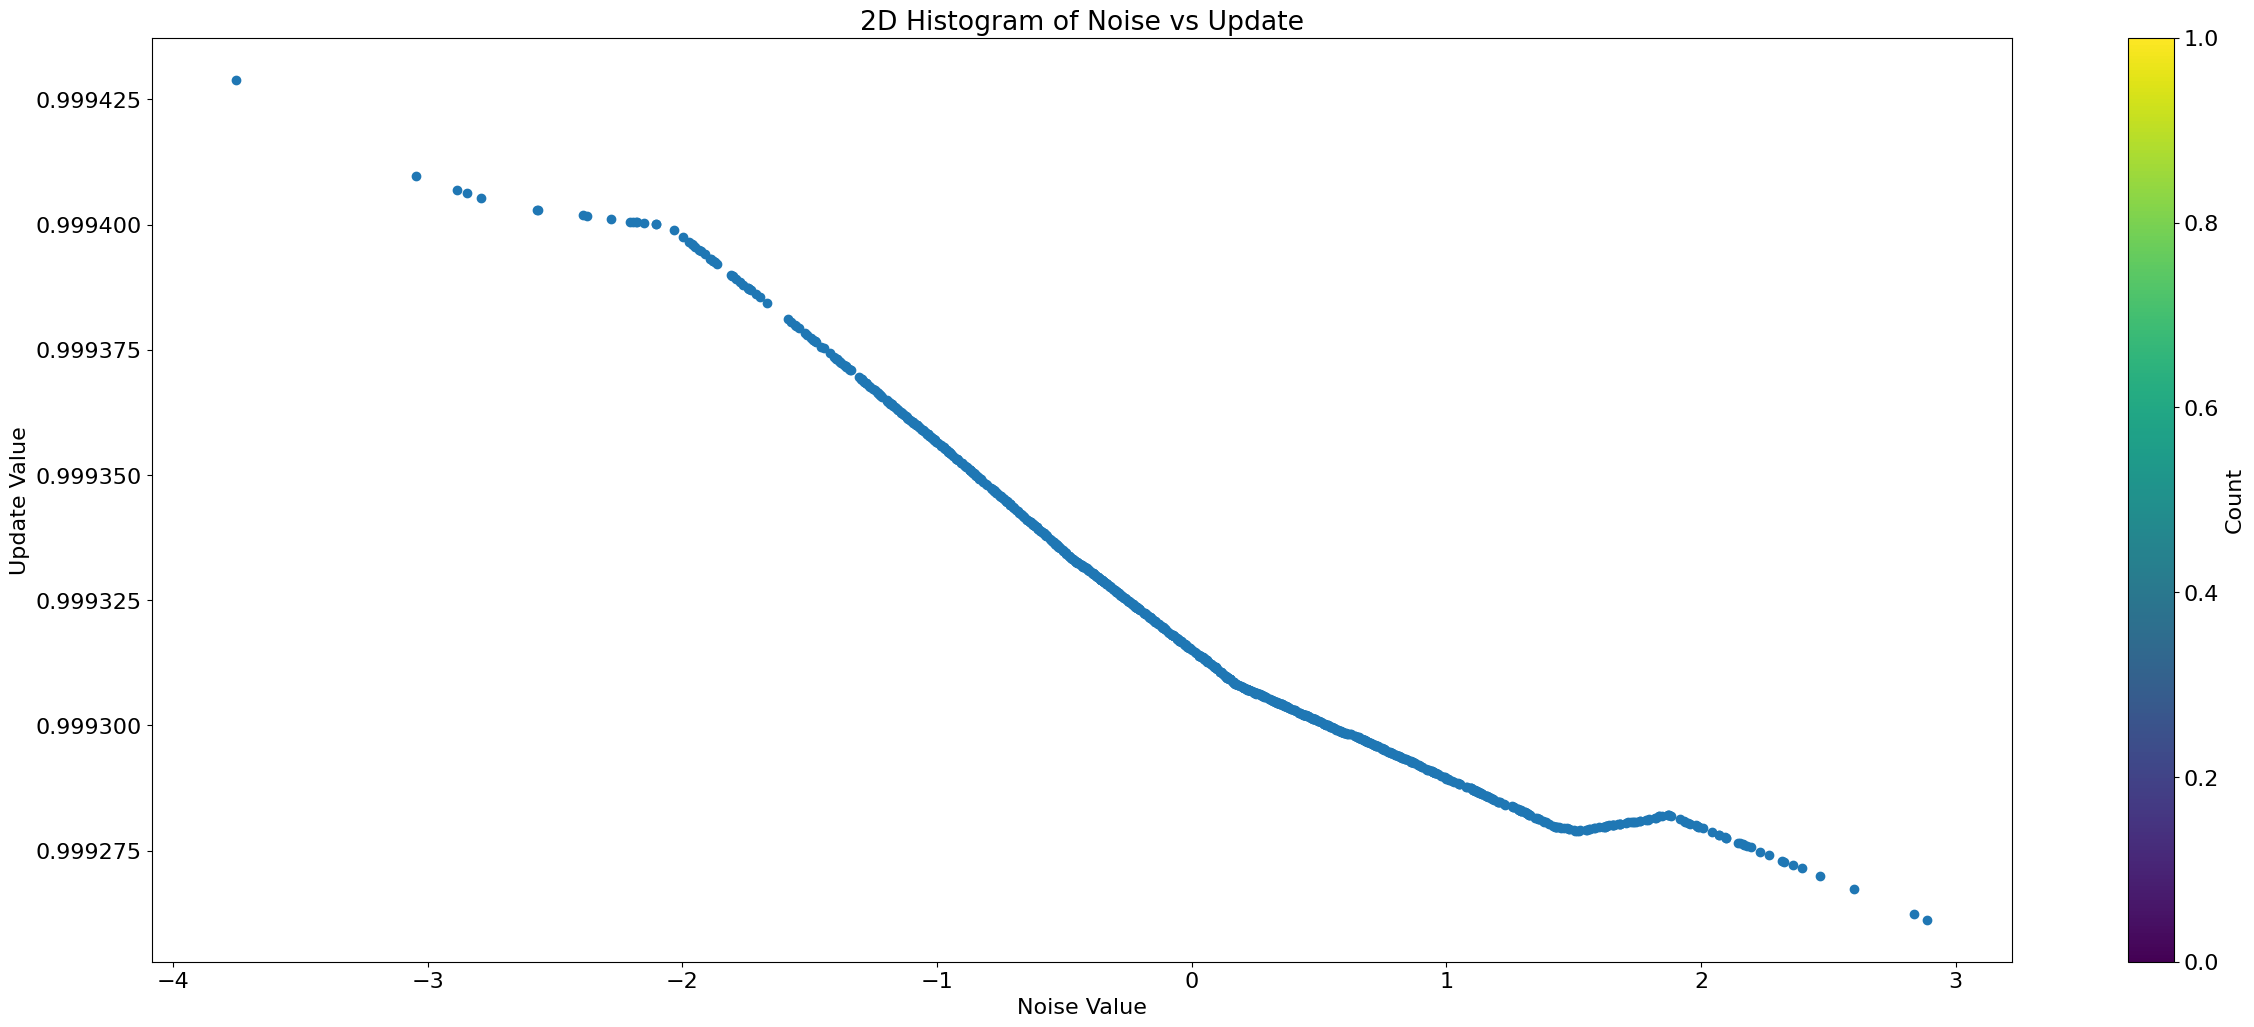

In [93]:
# Create 2D histogram
plt.scatter(noise_values[:,points[0],points[1]].flatten(), all_outputs.squeeze(1)[:,0, points[0], points[1]].flatten(),  cmap='viridis', norm=plt.cm.colors.LogNorm())
# plot 
plt.colorbar(label='Count')
plt.xlabel('Noise Value')
plt.ylabel('Update Value')
plt.title('2D Histogram of Noise vs Update')

In [94]:
np.argmax(all_outputs.squeeze(1)[:,:, points[0], points[1]], axis=1).flatten()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

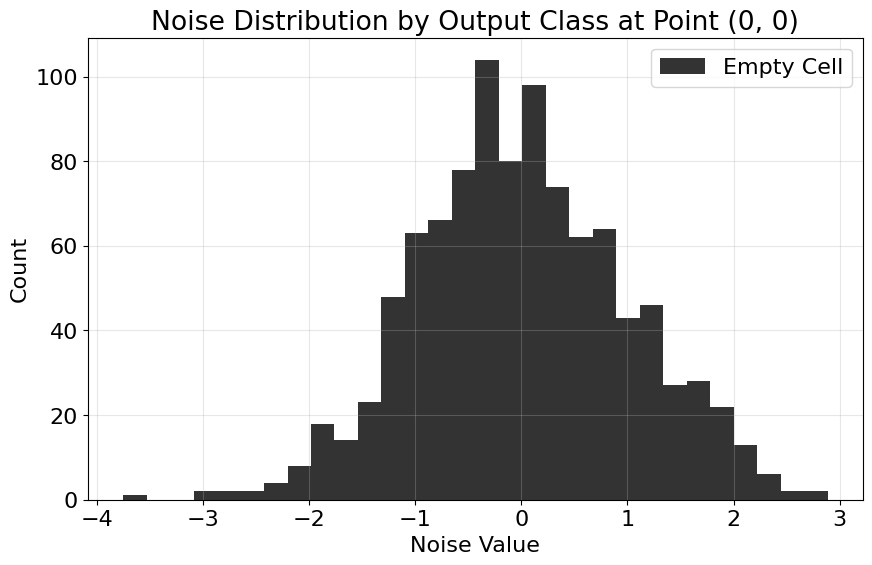

In [95]:
# Flatten the noise values and get output classes
flat_noise = noise_values[:,points[0],points[1]].flatten()
output_classes = np.argmax(all_outputs.squeeze(1)[:,:, points[0], points[1]], axis=1).flatten()

labels = {0 : "Empty Cell", 4 : "Differentiated 1", 1 : "Stem"}
colors = {0 : "black", 4 : "darkblue", 1 : "darkblue"}

# Create histogram
plt.figure(figsize=(10, 6))
for cls in np.unique(output_classes):
    mask = output_classes == cls
    plt.hist(flat_noise[mask], bins= round(30000 / sum(output_classes == cls) ) , alpha=0.8, label=labels[cls], color = colors[cls])

plt.xlabel('Noise Value')
plt.ylabel('Count')
plt.title(f'Noise Distribution by Output Class at Point ({points[0]}, {points[1]})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [96]:
for cls in np.unique(output_classes):
    print(cls, sum(output_classes == cls))

748 / 252

0 1000


2.9682539682539684

/home/salvatore.milite/miniconda3/envs/automata_project/lib/python3.11/site-packages/numpy/core/function_base.py:158: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/salvatore.milite/miniconda3/envs/automata_project/lib/python3.11/site-packages/numpy/core/function_base.py:168: RuntimeWarning: invalid value encountered in add
  y += start


IndexError: boolean index did not match indexed array along dimension 1; dimension is 1 but corresponding boolean dimension is 30

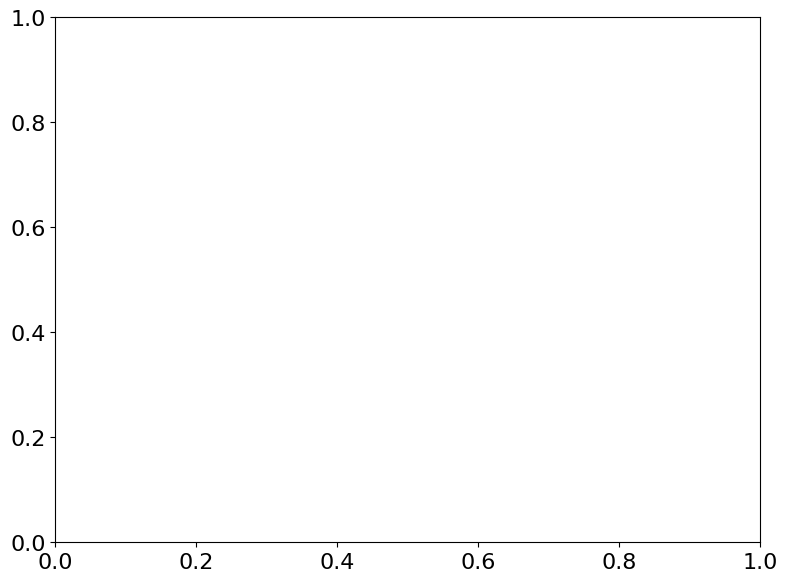

In [97]:

# Create figure with multiple visualizations
fig = plt.figure(figsize=(20, 15))

# 1. Conditional violin plot
plt.subplot(2, 2, 1)

# Bin the noise values
noise_min, noise_max = noise_values.min(), noise_values.max()
bin_edges = np.linspace(noise_min, noise_max, 10+1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Assign each noise value to a bin
bin_indices = np.digitize(noise_values, bin_edges) - 1
bin_indices = np.clip(bin_indices, 0, 10-1)  # Ensure valid indices

# Collect updates for each noise bin
binned_updates = [all_outputs[bin_indices == i] for i in range(10)]

# Create violin plot
parts = plt.violinplot(binned_updates, positions=bin_centers, 
                        showmeans=True, showextrema=True)

# Customize violin plot
for pc in parts['bodies']:
    pc.set_facecolor('skyblue')
    pc.set_alpha(0.7)

plt.xlabel('Noise Value')
plt.ylabel('Update Value')
plt.title(f'Distribution of Updates Given Noise (Rule 0, Channel 0)')
plt.grid(True, linestyle='--', alpha=0.7)